In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# 读取数据集
data = pd.read_csv("/root/2023mcm/new_data.csv")

In [2]:
from pykalman import KalmanFilter
# 选取需要处理的列
cols = [6, 7, 8, 9, 10, 11, 12]
data_sub = data.iloc[:, cols].values

# 创建Kalman滤波器
kf = KalmanFilter(initial_state_mean=data_sub[0], n_dim_obs=7)
# 进行滤波
filtered_state_means, filtered_state_covariances = kf.filter(data_sub)

# 将滤波结果保存回原数据中
data.iloc[:, cols] = filtered_state_means
# 准备数据集
X = data.iloc[:, [12, 13, 14, 15, 16, 17, 19,20]].values
y = data.iloc[:, 5:12].values

In [3]:
scaler_X = MinMaxScaler()
scaler_y=MinMaxScaler()
X = scaler_X.fit_transform(X)
y=scaler_y.fit_transform(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 将数据转换为张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM 网络模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, l1=0, l2=0.0005):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.l1 = nn.L1Loss(l1) if l1 > 0 else None
        self.l2 = nn.MSELoss(l2) if l2 > 0 else None

    def forward(self, x):
        x = x.view(len(x), 1, -1) 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        if self.l1 is not None:
            reg_loss = self.l1(self.fc.weight, torch.zeros_like(self.fc.weight))
            out += reg_loss
        if self.l2 is not None:
            reg_loss = self.l2(self.fc.weight, torch.zeros_like(self.fc.weight))
            out += reg_loss
        return out


# 训练函数
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        # 训练模型
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 计算训练集和测试集上的损失
        train_loss.append(total_loss / len(train_loader))
        with torch.no_grad():
            model.eval()
            test_loss.append(get_loss(model, criterion, test_loader))

        # 打印损失
        if (epoch+1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")

    return train_loss, test_loss
def get_loss(model, criterion, dataloader):
    total_loss = 0
    total_count = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        total_loss += loss.item() * X.size(0)
        total_count += X.size(0)
    return total_loss / total_count

# 设置超参数
input_size = 10
hidden_size = 64
num_layers = 1
output_size = 7
num_epochs =10000
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型、损失函数和优化器
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.0005)

from torch.utils.data import DataLoader, TensorDataset

# 将数据转换为 Dataset 对象
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 创建 DataLoader 对象，指定批次大小
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 1000/10000, Train Loss: 0.0244, Test Loss: 0.0239
Epoch 2000/10000, Train Loss: 0.0232, Test Loss: 0.0237
Epoch 3000/10000, Train Loss: 0.0229, Test Loss: 0.0237
Epoch 4000/10000, Train Loss: 0.0228, Test Loss: 0.0238
Epoch 5000/10000, Train Loss: 0.0228, Test Loss: 0.0238
Epoch 6000/10000, Train Loss: 0.0227, Test Loss: 0.0238
Epoch 7000/10000, Train Loss: 0.0226, Test Loss: 0.0239
Epoch 8000/10000, Train Loss: 0.0226, Test Loss: 0.0239
Epoch 9000/10000, Train Loss: 0.0225, Test Loss: 0.0240
Epoch 10000/10000, Train Loss: 0.0225, Test Loss: 0.0240


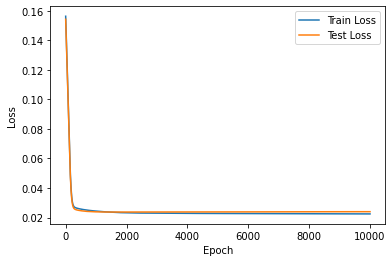

In [5]:
# 训练模型
train_loss, test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)


#可视化训练过程中的损失值
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 将测试集输入到模型中，得到预测值
y_pred = model(X_test.to(device)).detach().cpu().numpy()
np.shape(y_pred),np.shape(y_test)
for i in range(7):
    plt.plot(y_pred[:,i])
    plt.show()

Dimension 1: MSE = 20.843057415473815, RMSE = 4.565419741433838, MAE = 2.9354902931119105
Dimension 2: MSE = 2625.933416590379, RMSE = 51.24386223334829, MAE = 39.80260060639004
Dimension 3: MSE = 30365.050178970854, RMSE = 174.25570343311824, MAE = 141.69614466990217
Dimension 4: MSE = 4577.846927711901, RMSE = 67.65978811459507, MAE = 50.877680067480114
Dimension 5: MSE = 12138.783024040249, RMSE = 110.17614544010989, MAE = 89.35224267848125
Dimension 6: MSE = 9439.598503529913, RMSE = 97.15759622144793, MAE = 79.57587619738773
Dimension 7: MSE = 3414.9780059981276, RMSE = 58.43781315208611, MAE = 43.48926107232529


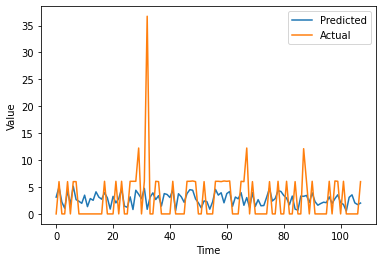

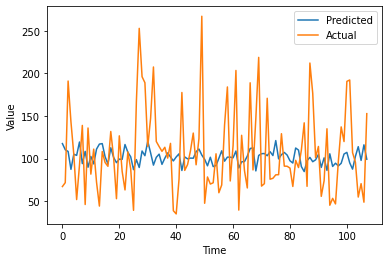

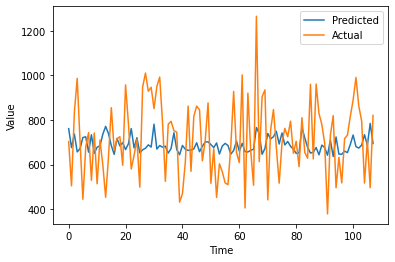

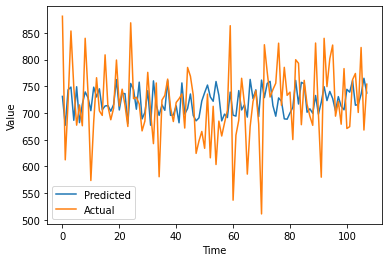

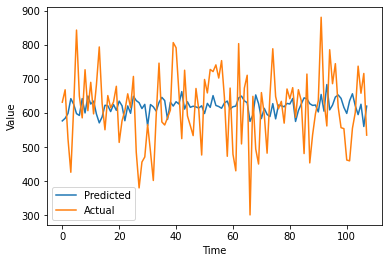

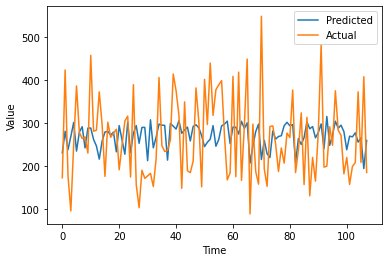

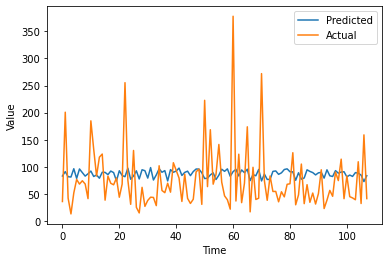

array([[3.11736774e+00, 1.17543831e+02, 7.61096802e+02, 7.31149719e+02,
        5.76818054e+02, 2.30417740e+02, 8.28704071e+01],
       [4.98657799e+00, 1.10336372e+02, 6.76199768e+02, 6.77177856e+02,
        5.84408325e+02, 2.80457123e+02, 9.09724197e+01],
       [2.18686676e+00, 1.08280167e+02, 7.36768188e+02, 7.43630737e+02,
        5.98647766e+02, 2.37580048e+02, 8.15251083e+01],
       [1.05632949e+00, 8.72746735e+01, 6.56991577e+02, 7.48591125e+02,
        6.42175049e+02, 2.68380341e+02, 8.09997864e+01],
       [4.30241728e+00, 1.05046402e+02, 6.71486877e+02, 6.86475830e+02,
        6.25515442e+02, 3.01040649e+02, 9.62874680e+01],
       [1.77472401e+00, 1.03701233e+02, 7.21500000e+02, 7.49282959e+02,
        5.98172607e+02, 2.34381073e+02, 7.83965607e+01],
       [5.15242577e+00, 1.19402290e+02, 7.24435852e+02, 6.82043762e+02,
        5.92840942e+02, 2.78770996e+02, 9.58445892e+01],
       [2.65739703e+00, 9.40128708e+01, 6.55870239e+02, 7.16648376e+02,
        6.42217651e+02, 2

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#scaler.fit(y)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)
# 计算每个维度的 MSE、RMSE 和 MAE
for i in range(7):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print("Dimension {}: MSE = {}, RMSE = {}, MAE = {}".format(i+1, mse, rmse, mae))
# 将每个维度的预测值和实际值都分别可视化
for i in range(7):
    plt.plot(y_pred[:, i], label="Predicted")
    plt.plot(y_test[:, i], label="Actual")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()
y_pred

In [8]:
import stats
#对于给定的输入 X，进行预测
X_new = np.array([[620,0, 1, 0, 3, 1, 1, 1,0.09318]]) # 举例子
#scaler.fit(X_new)
X_new = scaler_X.transform(X_new) # 归一化
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
model.eval() # 模型评估模式
with torch.no_grad():
    y_pred = model(X_new_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
    #scaler.fit(y)
    y_pred=scaler_y.inverse_transform(y_pred)
    print("预测值为：", y_pred)

ValueError: X has 9 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
from scipy import stats

def get_confidence_interval(model, X, alpha=0.05):
    """
    给定模型和输入，计算预测值和置信区间
    :param model: 已训练的模型
    :param X: 输入，形状为 (n_samples, n_features)
    :param alpha: 置信水平，默认为 0.05
    :return: 预测值、置信区间下界、置信区间上界
    """
    model.eval() # 模型评估模式
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
        y_pred = model(X_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
        n_samples = len(X)
        df = n_samples - model.hidden_size - 1 # 自由度
        se = np.sqrt(np.sum((model(X_tensor).cpu().numpy() - y)**2) / df) # 标准误差
        t = stats.t.ppf(1 - alpha/2, df) # t 分布的分位数
        lower = y_pred - t * se # 置信区间下界
        upper = y_pred + t * se # 置信区间上界
    return y_pred, lower, upper

y_pred, lower, upper = get_confidence_interval(model, X_new)
print("预测值为：", y_pred)
print("置信区间为：[{}, {}]".format(lower, upper))